In [1]:
import jax
import jax.numpy as jnp
import time
import optax
import matplotlib.pyplot as plt 
from functools import partial

# custom module
import lagrangian as lgr
import util
import plotting
from lnn import (
    LagrangianNN, 
    compute_loss, 
    train_step, 
    create_trajectory #for LNN 
)

In [2]:
m1 = 1.0
m2 = 1.0
k1 = 1.0
k2 = 1.0

In [3]:
def L_analytical(local):
    t = lgr.time(local)
    q = lgr.coordinate(local)
    v = lgr.velocity(local)
    
    x1, x2 = q
    v1, v2 = v
    
    # T = 1/2 m1 v1^2 + 1/2 m2 (v1 + v2)^2
    T = 0.5 * m1 * v1**2 + 0.5 * m2 * (v1 + v2)**2
    # V = 1/2 k1 x1^2 + 1/2 k2 x2^2
    V = 0.5 * k1 * x1**2 + 0.5 * k2 * x2**2
    
    return T - V

In [4]:
# to calculate total energy
def H_analytical(local):
    t = lgr.time(local)
    q = lgr.coordinate(local)
    v = lgr.velocity(local)
    
    x1, x2 = q
    v1, v2 = v

    T = 0.5 * m1 * v1**2 + 0.5 * m2 * (v1 + v2)**2
    V = 0.5 * k1 * x1**2 + 0.5 * k2 * x2**2
    
    return T + V

In [5]:
# hyperparameter
q_dim = 2
hidden_dim = 256 
learning_rate = 1e-3
num_epochs = 50000
batch_size = 1024
#test_size = 512

key = jax.random.PRNGKey(0)

In [6]:
print("--- 学習用・テスト用データセットの生成開始 ---")

# --- analytical data generator---
ds_true = lgr.state_derivative(L_analytical) 
solver_true = util.ode_solver(ds_true)
a_true_func = lgr.lagrangian_to_acceleration(L_analytical) 
vmap_a_true_func = jax.vmap( #to use jax.jit
    lambda t, q, v: a_true_func((t, q, v)), 
    in_axes=(0, 0, 0)
)

# --- setup trajectory of training and test data ---
num_train_trajectories = 25  # 学習用の軌道数
num_test_trajectories = 25   # テスト用の軌道数
N_points_per_traj = 500      # 1軌道あたりの点の数
t_end = 25.0                 # 1軌道のシミュレーション時間
t_eval = jnp.linspace(0.0, t_end, N_points_per_traj)

train_t_list, train_q_list, train_v_list, train_a_list = [], [], [], []
test_t_list, test_q_list, test_v_list, test_a_list = [], [], [], []

# --- generate training datasets---
print(f"Generating {num_train_trajectories} training trajectories...")
for i in range(num_train_trajectories):
    key, q_key, v_key = jax.random.split(key, 3)
    
    # randomly determine initial state
    q0 = jax.random.uniform(q_key, shape=(q_dim,), minval=-1.5, maxval=1.5)
    v0 = jax.random.uniform(v_key, shape=(q_dim,), minval=-1.5, maxval=1.5)
    initial_state = (0.0, q0, v0)
    
    # make (correct) trajectory
    t_traj, q_traj, v_traj = solver_true(initial_state, t_eval)
    a_traj = vmap_a_true_func(t_traj, q_traj, v_traj)
    
    train_t_list.append(t_traj)
    train_q_list.append(q_traj)
    train_v_list.append(v_traj)
    train_a_list.append(a_traj)

# --- generate test datasets ---
print(f"Generating {num_test_trajectories} test trajectories...")
for i in range(num_test_trajectories):
    key, q_key, v_key = jax.random.split(key, 3)
    
    q0 = jax.random.uniform(q_key, shape=(q_dim,), minval=-1.5, maxval=1.5)
    v0 = jax.random.uniform(v_key, shape=(q_dim,), minval=-1.5, maxval=1.5)
    initial_state = (0.0, q0, v0)
    
    t_traj, q_traj, v_traj = solver_true(initial_state, t_eval)
    
    a_traj = vmap_a_true_func(t_traj, q_traj, v_traj)
    
    test_t_list.append(t_traj)
    test_q_list.append(q_traj)
    test_v_list.append(v_traj)
    test_a_list.append(a_traj)

train_t = jnp.concatenate(train_t_list, axis=0)
train_q = jnp.concatenate(train_q_list, axis=0)
train_v = jnp.concatenate(train_v_list, axis=0)
train_targets = jnp.concatenate(train_a_list, axis=0)

test_t = jnp.concatenate(test_t_list, axis=0)
test_q = jnp.concatenate(test_q_list, axis=0)
test_v = jnp.concatenate(test_v_list, axis=0)
test_targets = jnp.concatenate(test_a_list, axis=0)

#train_states = (train_t, train_q, train_v) 
test_dataset_states = (test_t, test_q, test_v) 
test_dataset_true_accel = test_targets  

N_train_total = train_q.shape[0] # 全学習ポイント数
print(f"--- データセット生成完了 (Total Train Points: {N_train_total}) ---")

--- 学習用・テスト用データセットの生成開始 ---
Generating 25 training trajectories...
Generating 25 test trajectories...
--- データセット生成完了 (Total Train Points: 12500) ---


In [7]:
'''
・learning process
During training, we sample a mini-batch of batch_size points from multiple different trajectories. 
For testing, we evaluate the model on all data points from the entire test set, which consists of multiple generated trajectories. 
The loss function is the Mean Squared Error (MSE) of the acceleration
'''

# --- モデルとオプティマイザの初期化 ---
lnn_model = LagrangianNN(hidden_dim=hidden_dim)
model_apply_fn = lnn_model.apply  # jitで使用できるようにするためapplyというメソッドを変数に割り当てる。

key, init_key = jax.random.split(key) #同じkeyを与えると同じ値を毎回与える

# モデルを初期化するためのダミー入力 (t, q, v)
# q と v は q_dim に合わせる
dummy_q = jnp.zeros((q_dim,))
dummy_v = jnp.zeros((q_dim,))
dummy_state = (0.0, dummy_q, dummy_v)

params = lnn_model.init(init_key, dummy_state)['params'] #構造を決定
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params) #重みを追跡するために必要な内部メモリを作成する

print("モデルとオプティマイザの初期化完了。学習を開始します...")

start_train_time = time.time()

# --- 学習ループ ---
for epoch in range(num_epochs):
    
    # randomly choose trajectory 
    key, data_key = jax.random.split(key)
    indices = jax.random.choice(data_key, N_train_total, shape=(batch_size,), replace=False)
    
    # make mini batch
    t_batch = train_t[indices]
    q_batch = train_q[indices]
    v_batch = train_v[indices]
    
    batch_states = (t_batch, q_batch, v_batch)
    batch_true_accel = train_targets[indices]
    
    params, opt_state, train_loss = train_step(
        params, 
        opt_state, 
        optimizer, 
        model_apply_fn, 
        batch_states, 
        batch_true_accel
    )
    
    if epoch % 500 == 0:
        test_loss = compute_loss(
            params,
            model_apply_fn,
            test_dataset_states,
            test_dataset_true_accel
        )
        print(f"Epoch {epoch}, Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}")

print("学習完了。")

# Final Test Loss
final_test_loss = compute_loss(params, model_apply_fn, test_dataset_states, test_dataset_true_accel)
final_test_loss.block_until_ready()
end_train_time = time.time()
print(f"--- Final Test Loss: {final_test_loss:.6f} ---")
print(f"--- Total Training Time: {end_train_time - start_train_time:.2f} seconds ---")

モデルとオプティマイザの初期化完了。学習を開始します...
Epoch 0, Train Loss: 89846.992188, Test Loss: 9136.702148
Epoch 500, Train Loss: 6.029761, Test Loss: 4.843923
Epoch 1000, Train Loss: 5.907968, Test Loss: 4.843199
Epoch 1500, Train Loss: 5.897138, Test Loss: 4.841998
Epoch 2000, Train Loss: 5.870850, Test Loss: 4.840210
Epoch 2500, Train Loss: 5.817420, Test Loss: 4.837693
Epoch 3000, Train Loss: 5.931884, Test Loss: 4.834250
Epoch 3500, Train Loss: 5.876009, Test Loss: 4.829652
Epoch 4000, Train Loss: 6.007220, Test Loss: 4.823567
Epoch 4500, Train Loss: 5.753715, Test Loss: 4.815721
Epoch 5000, Train Loss: 5.975439, Test Loss: 4.805597
Epoch 5500, Train Loss: 5.626705, Test Loss: 4.792675
Epoch 6000, Train Loss: 5.862026, Test Loss: 4.776093
Epoch 6500, Train Loss: 6.065627, Test Loss: 4.755192
Epoch 7000, Train Loss: 6.005589, Test Loss: 4.728907
Epoch 7500, Train Loss: 6.089281, Test Loss: 4.696025
Epoch 8000, Train Loss: 5.708631, Test Loss: 4.655228
Epoch 8500, Train Loss: 5.472557, Test Loss: 4.60

In [10]:
'''
・generate one arbitrary trafectory
we use a graph to verify whether predictions can be made for an arbitrary trajectory, 
independent of the data used for training and testing
'''
print("軌道を生成して、真の挙動と比較します...")
solver_learned = create_trajectory(model_apply_fn, params)
ds_true = lgr.state_derivative(L_analytical)
solver_true = util.ode_solver(ds_true)

# arbitrary initial state
initial_state = (0.0, jnp.array([1.0, 0.5]), jnp.array([0.0, 0.0]))
t_eval = jnp.linspace(0.0, 150.0, 3000) #use long time to see how error increases
learned_trajectory = solver_learned(initial_state, t_eval)

start_inference_time = time.time()
learned_trajectory[1].block_until_ready() 
end_inference_time = time.time()
print(f"--- Trajectory Inference Time: {end_inference_time - start_inference_time:.4f} seconds ---")

true_trajectory = solver_true(initial_state, t_eval)
print("軌道生成が完了しました。")

軌道を生成して、真の挙動と比較します...
--- Trajectory Inference Time: 1.1310 seconds ---
軌道生成が完了しました。


プロットを実行します...
Plotting Coordinate 1 (q1, v1)...


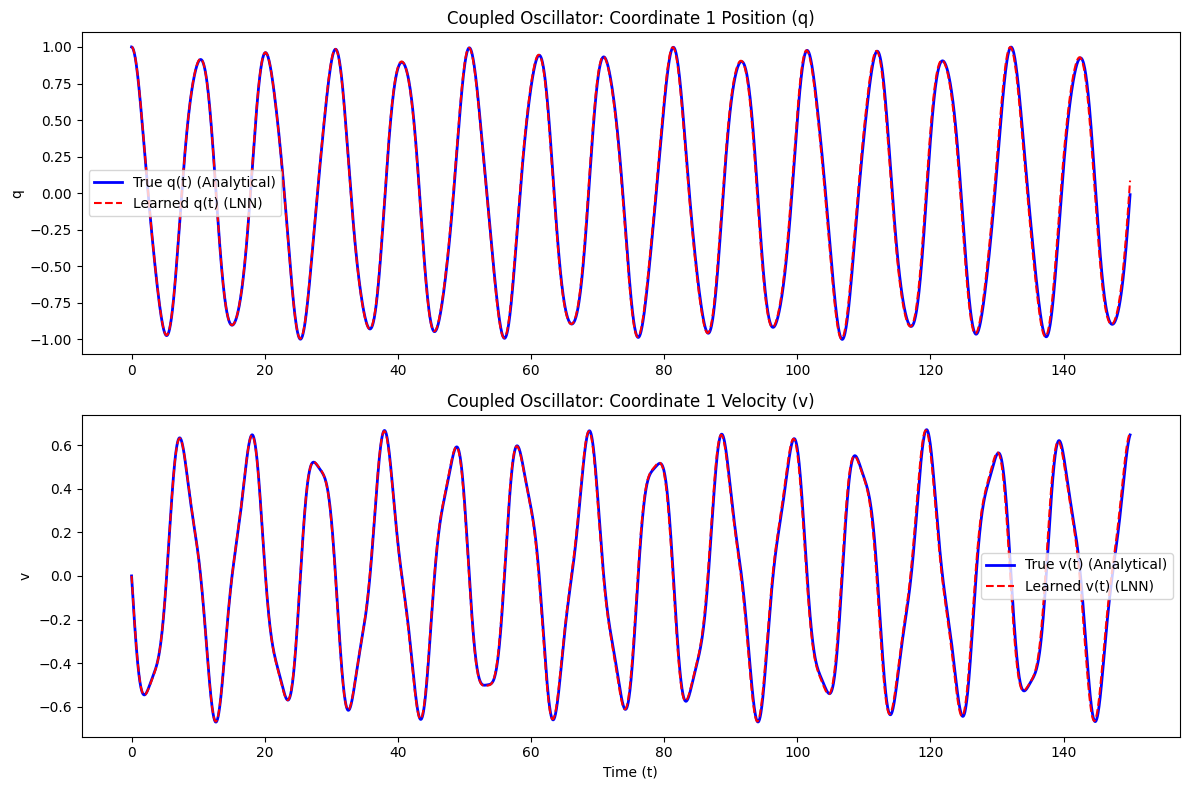

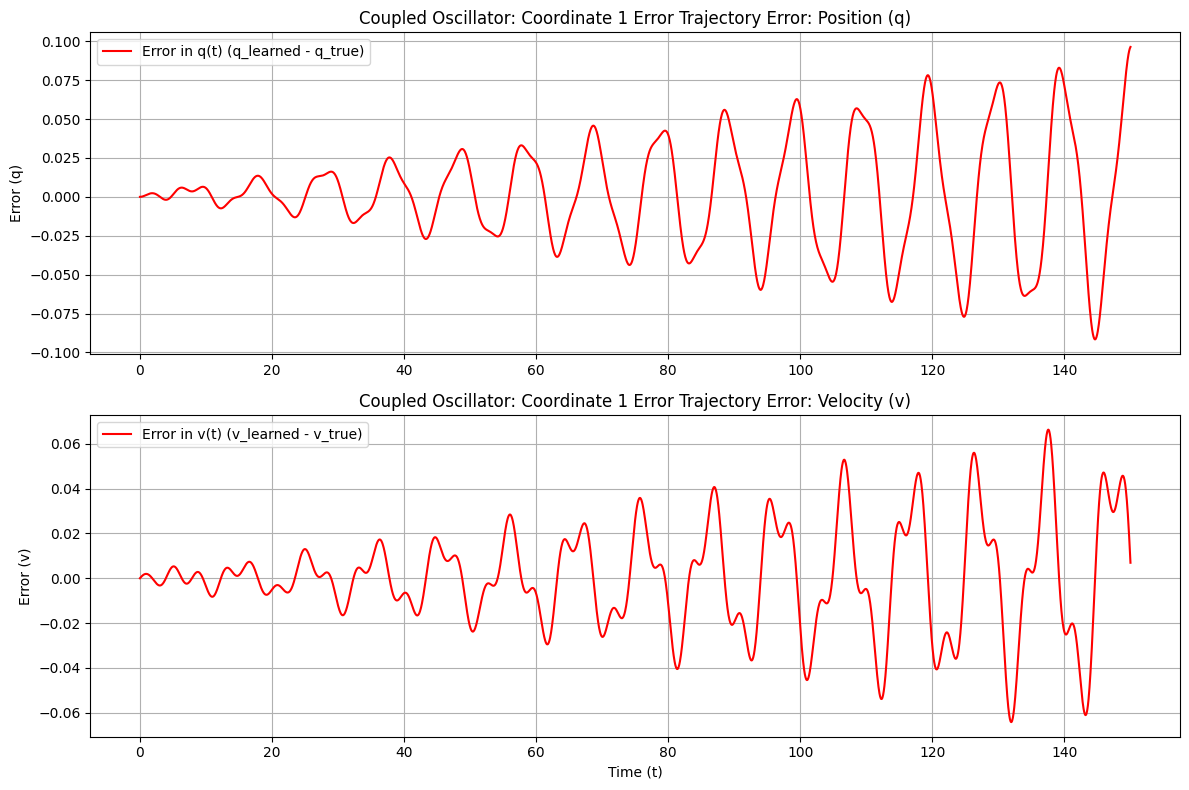

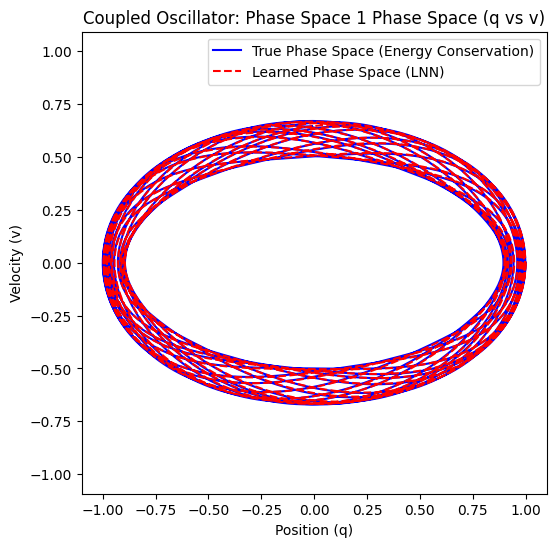

Plotting Coordinate 2 (q2, v2)...


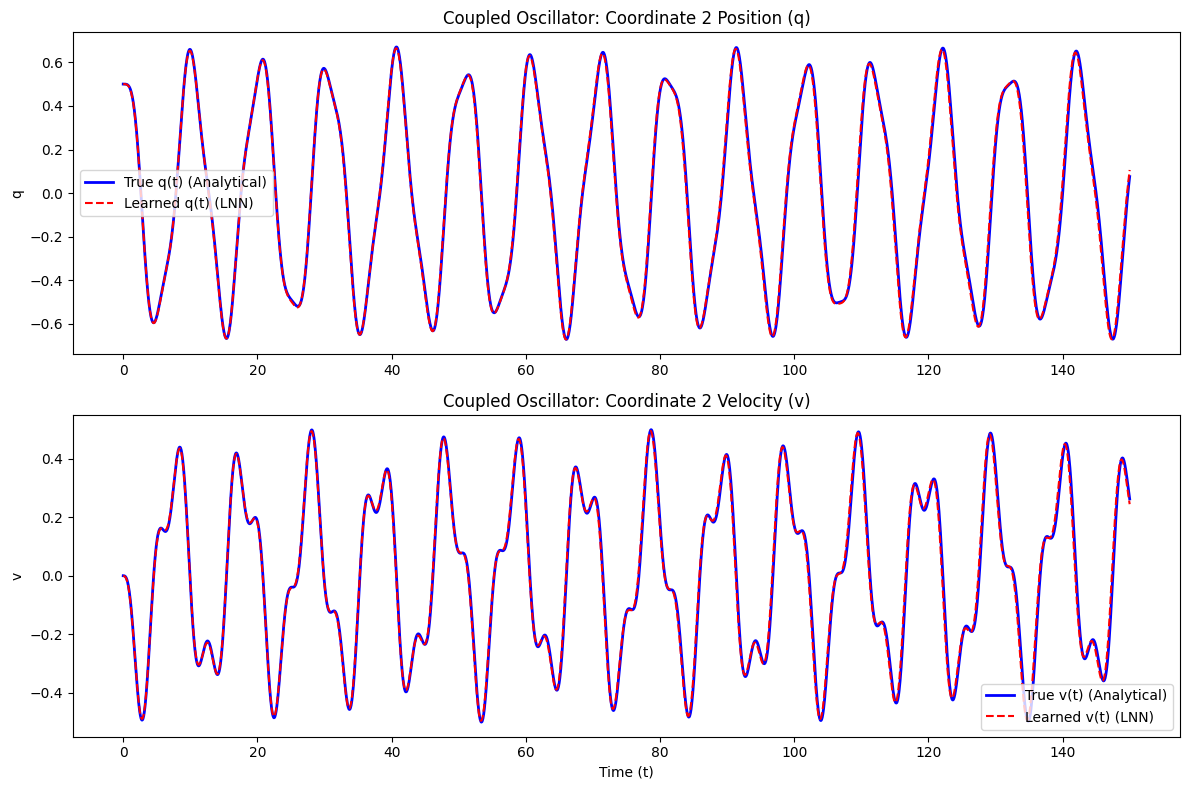

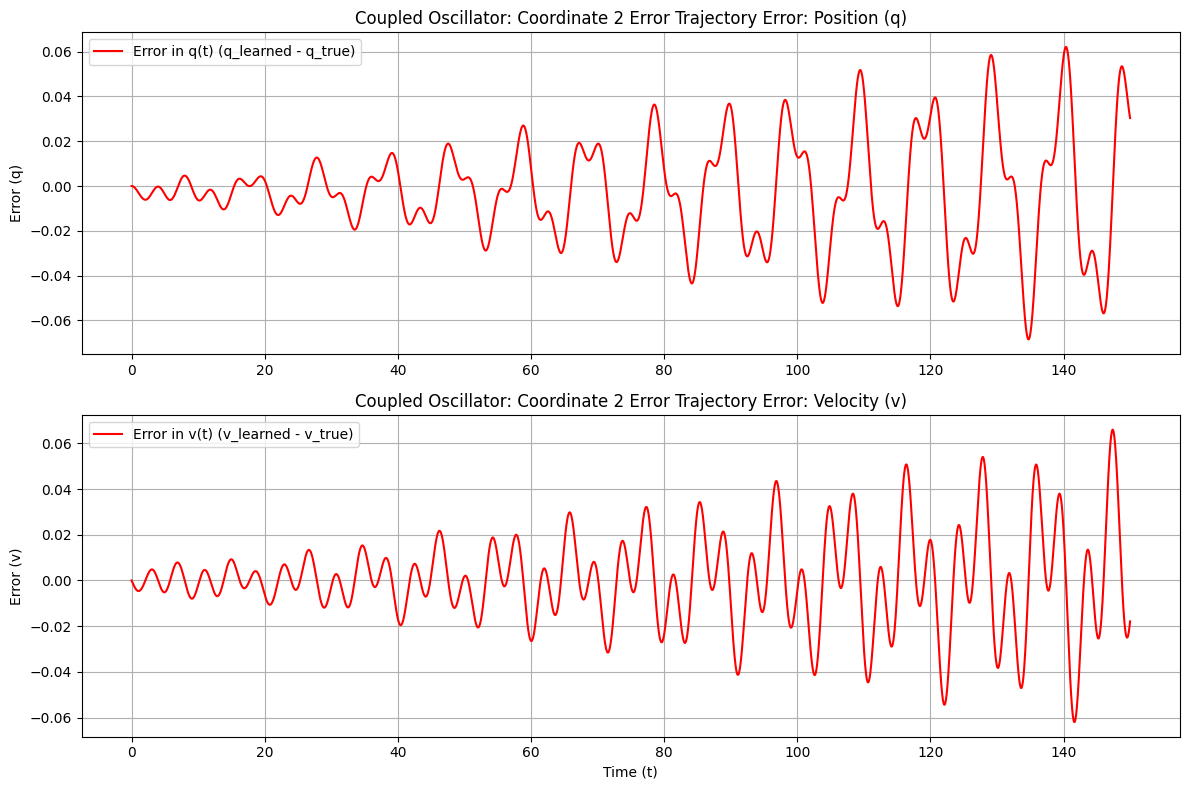

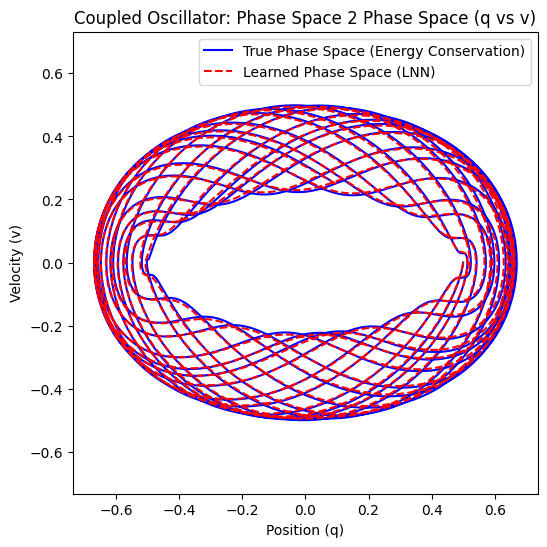

Plotting Energy...


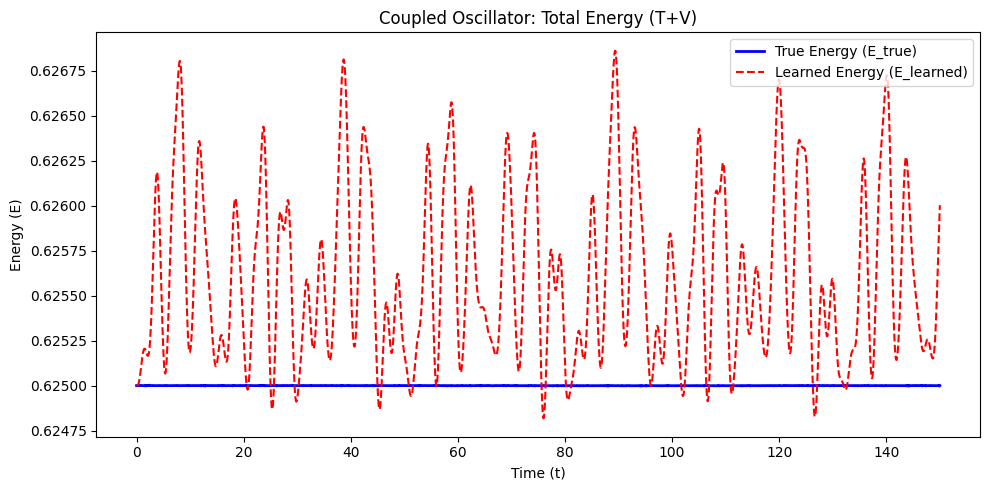

プロット完了。


In [11]:
'''
・plotting
'''
print("プロットを実行します...")

t_learned, q_learned, v_learned = learned_trajectory 
t_true, q_true, v_true = true_trajectory 

# --- エネルギー計算 ---
vmap_H_func = jax.vmap(
    lambda t, q, v: H_analytical((t, q, v)), 
    in_axes=(0, 0, 0)
)
E_true = vmap_H_func(t_true, q_true, v_true)
E_learned = vmap_H_func(t_learned, q_learned, v_learned)

# --- プロット実行 (2Dに対応) ---
title_prefix="Coupled Oscillator:"

# --- 座標 1 (x1, v1) のプロット ---
print("Plotting Coordinate 1 (q1, v1)...")
plotting.plot_trajectory_comparison(
    t_true, q_true[:, 0], v_true[:, 0], 
    t_learned, q_learned[:, 0], v_learned[:, 0],
    f"{title_prefix} Coordinate 1"
)
plotting.plot_trajectory_error(
    t_true,
    q_true[:, 0], v_true[:, 0],
    q_learned[:, 0], v_learned[:, 0],
    title_prefix=f"{title_prefix} Coordinate 1 Error"
)
plotting.plot_phase_space(
    q_true[:, 0], v_true[:, 0], 
    q_learned[:, 0], v_learned[:, 0],
    f"{title_prefix} Phase Space 1"
)

# --- 座標 2 (x2, v2) のプロット ---
print("Plotting Coordinate 2 (q2, v2)...")
plotting.plot_trajectory_comparison(
    t_true, q_true[:, 1], v_true[:, 1], 
    t_learned, q_learned[:, 1], v_learned[:, 1],
    f"{title_prefix} Coordinate 2"
)
plotting.plot_trajectory_error(
    t_true,
    q_true[:, 1], v_true[:, 1],
    q_learned[:, 1], v_learned[:, 1],
    title_prefix=f"{title_prefix} Coordinate 2 Error"
)
plotting.plot_phase_space(
    q_true[:, 1], v_true[:, 1], 
    q_learned[:, 1], v_learned[:, 1],
    f"{title_prefix} Phase Space 2"
)

# --- エネルギーのプロット ---
print("Plotting Energy...")
plotting.plot_energy_comparison(
    t_true,
    E_true,
    E_learned,
    title_prefix
)
print("プロット完了。")